# Project: **Real time Traffic Sign Recognition** 
**In this project, We used Python and TensorFlow to classify traffic signs.**



## Pipeline architecture:
- **Load The Data.**
- **Dataset Summary & Exploration**
- **Data Preprocessing**.
    - Shuffling.
    - Grayscaling.
    - Local Histogram Equalization.
    - Normalization.
- **Design a Model Architecture.**
    - LeNet-5.
    - VGGNet.
- **Model Training and Evaluation.**
- **Testing the Model Using the Test Set.**
- **Testing the Model on New Images.**

In [ ]:
!pip install tensorflow==1.15
!pip install gTTS
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 412.3 MB 18 kB/s 
     |████████████████████████████████| 50 kB 3.6 MB/s 
     |████████████████████████████████| 503 kB 63.7 MB/s 
     |████████████████████████████████| 3.8 MB 62.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7553 sha256=eeeb9358eecb57d54b0f994f3bd3ec99115fa9e98deadb804cf3ea713cc2e72f
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [ ]:
# Importing Python libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix

# is it using the GPU?
print(tf.test.gpu_device_name())

# Show current TensorFlow version
tf.__version__

/device:GPU:0


'1.15.0'

---
## Step 1: Load The Data

We have a pickled dataset in which we've already resized the images to 32x32.

We already have three `.p` files of 32x32 resized images:
- `train.p`: The training set.
- `test.p`: The testing set.
- `valid.p`: The validation set.

We will use Python `pickle` to load the data.

Load Dataset from the Google Drive

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id1 = '1PEgpZa170KKIvJ8Ee3asriykB7l4HDqo'
downloaded = drive.CreateFile({'id': file_id1})
downloaded.GetContentFile('signnames.csv')

file_id2 = '13t6lOw_aDvk3hOQxIUTGUQ5fwcpIVosM'
downloaded = drive.CreateFile({'id': file_id2})
downloaded.GetContentFile('traffic-signs-data.zip')

In [ ]:
# Dataset from cdn
!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
!wget https://map-preview-images.s3.amazonaws.com/Fonts/signnames.csv
!unzip /content/traffic-signs-data.zip -d "/content/"

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

--2021-07-29 06:35:44--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 13.225.205.207, 13.225.205.196, 13.225.205.223, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|13.225.205.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M  54.3MB/s    in 2.2s    

2021-07-29 06:35:46 (54.3 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]

--2021-07-29 06:35:46--  https://map-preview-images.s3.amazonaws.com/Fonts/signnames.csv
Resolving map-preview-images.s3.amazonaws.com (map-preview-images.s3.amazonaws.com)... 52.219.66.72
Connecting to map-preview-images.s3.amazonaws.com (map-preview-images.s3.amazonaws.com)|52.219.66.72|:443... connected.
HTTP request sent, awai

In [ ]:
# Mapping ClassID to traffic sign names
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

---

## Step 2: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

The code snippets below will provide a basic summery of the Dataset.

**First, we will use `numpy` provide the number of images in each subset, in addition to the image size, and the number of unique classes.**

In [ ]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


**Then, we will use `matplotlib` plot sample images from each subset.**

In [ ]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

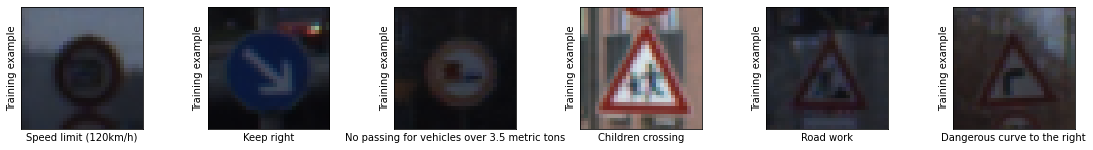

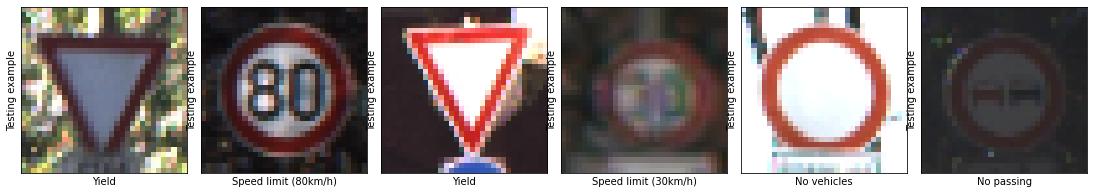

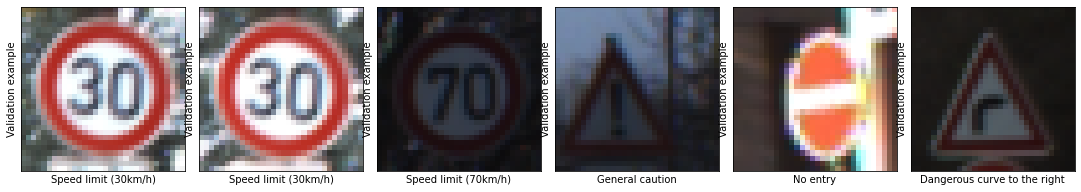

In [ ]:
# Plotting sample examples
list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")
list_images(X_valid, y_valid, "Validation example")

**And finally, we will use `numpy` to plot a histogram of the count of images in each unique class.**

In [ ]:
def histogram_plot(dataset, label):
    """
    Plots a histogram of the input data.
        Parameters:
            dataset: Input data to be plotted as a histogram.
            lanel: A string to be used as a label for the histogram.
    """
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()

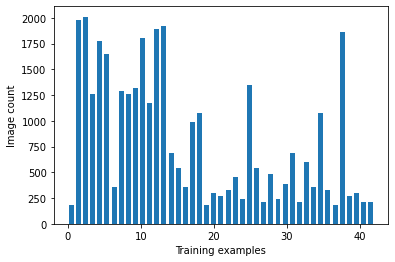

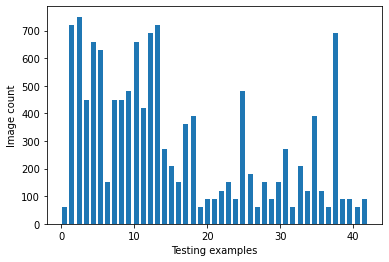

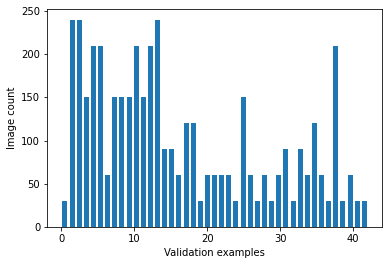

In [ ]:
# Plotting histograms of the count of each sign
histogram_plot(y_train, "Training examples")
histogram_plot(y_test, "Testing examples")
histogram_plot(y_valid, "Validation examples")

---

## Step 3: Data Preprocessing

In this step, we will apply several preprocessing steps to the input images to achieve the best possible results.

**We will use the following preprocessing techniques:**
1. Shuffling.
2. Grayscaling.
3. Local Histogram Equalization.
4. Normalization.

1.
**Shuffling**: In general, we shuffle the training data to increase randomness and variety in training dataset, in order for the model to be more stable. We will use `sklearn` to shuffle our data.

In [ ]:
X_train, y_train = shuffle(X_train, y_train)

2.
**Grayscaling**: In their paper ["Traffic Sign Recognition with Multi-Scale Convolutional Networks"](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) published in 2011, P. Sermanet and Y. LeCun stated that using grayscale images instead of color improves the ConvNet's accuracy. We will use `OpenCV` to convert the training images into grey scale.

In [ ]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

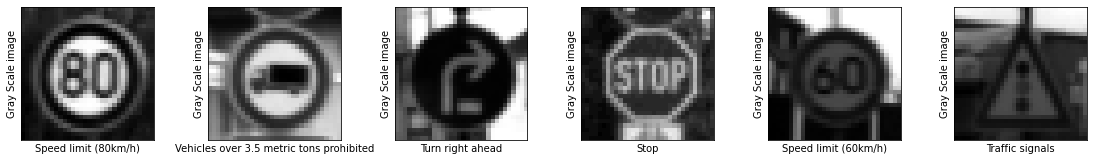

In [ ]:
# Sample images after greyscaling
gray_images = list(map(gray_scale, X_train))
list_images(gray_images, y_train, "Gray Scale image", "gray")

3.
**Local Histogram Equalization**: This technique simply spreads out the most frequent intensity values in an image, resulting in enhancing images with low contrast. Applying this technique will be very helpfull in our case since the dataset in hand has real world images, and many of them has low contrast. We will use `skimage` to apply local histogram equalization to the training images.

In [ ]:
def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

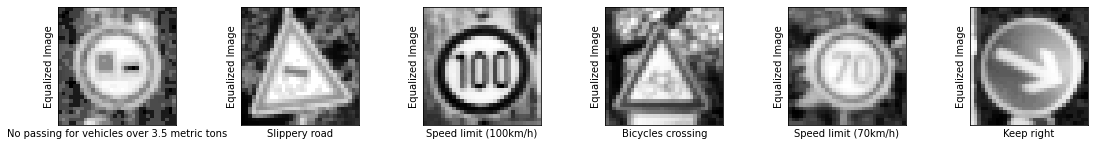

In [ ]:
# Sample images after Local Histogram Equalization
equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train, "Equalized Image", "gray")

4.
**Normalization**: Normalization is a process that changes the range of pixel intensity values. Usually the image data should be normalized so that the data has mean zero and equal variance.

In [ ]:
def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image

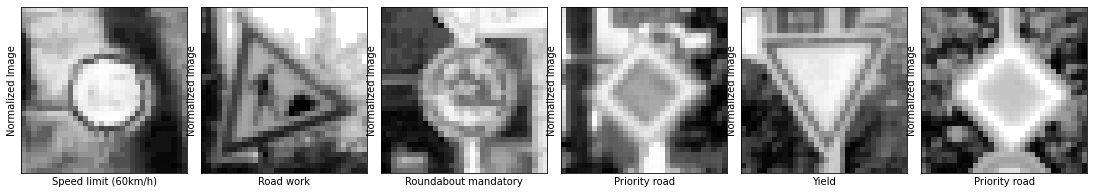

In [ ]:
# Sample images after normalization
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

In [ ]:
def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

---

## Step 4: Design a Model Architecture

In this step, we will design and implement a deep learning model that learns to recognize traffic signs from our dataset.

We'll use Convolutional Neural Networks to classify the images in this dataset. The reason behind choosing ConvNets is that they are designed to recognize visual patterns directly from pixel images with minimal preprocessing. They automatically learn hierarchies of invariant features at every level from data.
We will implement two of the most famous ConvNets.

**Notes**:
1. We specify the learning rate of 0.001, which tells the network how quickly to update the weights.
2. We minimize the loss function using the Adaptive Moment Estimation (Adam) Algorithm. Adam is an optimization algorithm introduced by D. Kingma and J. Lei Ba in a 2015 paper named [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980). Adam algorithm computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients like [Adadelta](https://arxiv.org/pdf/1212.5701.pdf) and [RMSprop](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) algorithms, Adam also keeps an exponentially decaying average of past gradients mtmt, similar to [momentum algorithm](http://www.sciencedirect.com/science/article/pii/S0893608098001166?via%3Dihub), which in turn produce better results.
3. we will run `minimize()` function on the optimizer which use backprobagation to update the network and minimize our training loss.

### 1.  LeNet-5
LeNet-5 is a convolutional network designed for handwritten and machine-printed character recognition. It was introduced by the famous [Yann LeCun](https://en.wikipedia.org/wiki/Yann_LeCun) in his paper [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) in 1998. Although this ConvNet is intended to classify hand-written digits, we're confident it have a very high accuracy when dealing with traffic signs, given that both hand-written digits and traffic signs are given to the computer in the form of pixel images.

**LeNet-5 architecture:**
<figure>
 <img src="LeNet.png" width="1072" alt="Combined Image" />
 <figcaption>
 <p></p> 
 </figcaption>
</figure>

This ConvNet follows these steps:

Input => Convolution => ReLU => Pooling => Convolution => ReLU => Pooling => FullyConnected => ReLU => FullyConnected

**Layer 1 (Convolutional):** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2 (Convolutional):** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flattening:** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

**Layer 3 (Fully Connected):** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4 (Fully Connected):** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5 (Fully Connected):** This should have 43 outputs.

In [ ]:
class LaNet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 28x28x6.
        self.filter1_width = 5
        self.filter1_height = 5
        self.input1_channels = 1
        self.conv1_output = 6
        # Weight and bias
        self.conv1_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter1_width, self.filter1_height, self.input1_channels, self.conv1_output),
            mean = self.mu, stddev = self.sigma))
        self.conv1_bias = tf.Variable(tf.zeros(self.conv1_output))
        # Apply Convolution
        self.conv1 = tf.nn.conv2d(x, self.conv1_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv1_bias
        
        # Activation:
        self.conv1 = tf.nn.relu(self.conv1)
        
        # Pooling: Input = 28x28x6. Output = 14x14x6.
        self.conv1 = tf.nn.max_pool(self.conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Layer 2 (Convolutional): Output = 10x10x16.
        self.filter2_width = 5
        self.filter2_height = 5
        self.input2_channels = 6
        self.conv2_output = 16
        # Weight and bias
        self.conv2_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter2_width, self.filter2_height, self.input2_channels, self.conv2_output),
            mean = self.mu, stddev = self.sigma))
        self.conv2_bias = tf.Variable(tf.zeros(self.conv2_output))
        # Apply Convolution
        self.conv2 = tf.nn.conv2d(self.conv1, self.conv2_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv2_bias
        
        # Activation:
        self.conv2 = tf.nn.relu(self.conv2)
        
        # Pooling: Input = 10x10x16. Output = 5x5x16.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Flattening: Input = 5x5x16. Output = 400.
        self.fully_connected0 = flatten(self.conv2)
        
        # Layer 3 (Fully Connected): Input = 400. Output = 120.
        self.connected1_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = self.mu, stddev = self.sigma))
        self.connected1_bias = tf.Variable(tf.zeros(120))
        self.fully_connected1 = tf.add((tf.matmul(self.fully_connected0, self.connected1_weights)), self.connected1_bias)
        
        # Activation:
        self.fully_connected1 = tf.nn.relu(self.fully_connected1)
    
        # Layer 4 (Fully Connected): Input = 120. Output = 84.
        self.connected2_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = self.mu, stddev = self.sigma))
        self.connected2_bias = tf.Variable(tf.zeros(84))
        self.fully_connected2 = tf.add((tf.matmul(self.fully_connected1, self.connected2_weights)), self.connected2_bias)
        
        # Activation.
        self.fully_connected2 = tf.nn.relu(self.fully_connected2)
    
        # Layer 5 (Fully Connected): Input = 84. Output = 43.
        self.output_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = self.mu, stddev = self.sigma))
        self.output_bias = tf.Variable(tf.zeros(43))
        self.logits =  tf.add((tf.matmul(self.fully_connected2, self.output_weights)), self.output_bias)

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.train.Saver()
    
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

### 2.  VGGNet
VGGNet was first introduced in 2014 by K. Simonyan and A. Zisserman from the University of Oxford in a paper called [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf). They were investigating the convolutional network depth on its accuracy in the large-scale image recognition setting. Their main contribution is a thorough evaluation of networks of increasing depth using an architecture with very small (3x3) convolution filters, which shows that a significant improvement on the prior-art configurations can be achieved by pushing the depth to 16-19 weight layers.

**VGGNet architecture:**
<figure>
 <img src="VGGNet.png" width="1072" alt="Combined Image" />
 <figcaption>
 <p></p> 
 </figcaption>
</figure>

The original VGGNet architecture has 16-19 layers, but I've excluded some of them and implemented a modified version of only 12 layers to save computational resources.

This ConvNet follows these steps:

Input => Convolution => ReLU => Convolution => ReLU => Pooling => Convolution => ReLU => Convolution => ReLU => Pooling => Convolution => ReLU => Convolution => ReLU => Pooling => FullyConnected => ReLU => FullyConnected => ReLU => FullyConnected

**Layer 1 (Convolutional):** The output shape should be 32x32x32.

**Activation.** Your choice of activation function.

**Layer 2 (Convolutional):** The output shape should be 32x32x32.

**Activation.** Your choice of activation function.

**Layer 3 (Pooling)** The output shape should be 16x16x32.

**Layer 4 (Convolutional):** The output shape should be 16x16x64.

**Activation.** Your choice of activation function.

**Layer 5 (Convolutional):** The output shape should be 16x16x64.

**Activation.** Your choice of activation function.

**Layer 6 (Pooling)** The output shape should be 8x8x64.

**Layer 7 (Convolutional):** The output shape should be 8x8x128.

**Activation.** Your choice of activation function.

**Layer 8 (Convolutional):** The output shape should be 8x8x128.

**Activation.** Your choice of activation function.

**Layer 9 (Pooling)** The output shape should be 4x4x128.

**Flattening:** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

**Layer 10 (Fully Connected):** This should have 128 outputs.

**Activation.** Your choice of activation function.

**Layer 11 (Fully Connected):** This should have 128 outputs.

**Activation.** Your choice of activation function.

**Layer 12 (Fully Connected):** This should have 43 outputs.

In [ ]:
class VGGnet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 32x32x32.
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # ReLu Activation.
        self.conv1 = tf.nn.relu(self.conv1)

        # Layer 2 (Convolutional): Input = 32x32x32. Output = 32x32x32.
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        # ReLu Activation.
        self.conv2 = tf.nn.relu(self.conv2)

        # Layer 3 (Pooling): Input = 32x32x32. Output = 16x16x32.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv)

        # Layer 4 (Convolutional): Input = 16x16x32. Output = 16x16x64.
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Activation.
        self.conv3 = tf.nn.relu(self.conv3)

        # Layer 5 (Convolutional): Input = 16x16x64. Output = 16x16x64.
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # ReLu Activation.
        self.conv4 = tf.nn.relu(self.conv4)

        # Layer 6 (Pooling): Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        # Layer 7 (Convolutional): Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Activation.
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 8 (Convolutional): Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Activation.
        self.conv6 = tf.nn.relu(self.conv6)

        # Layer 9 (Pooling): Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Flatten. Input = 4x4x128. Output = 2048.
        self.fc0   = flatten(self.conv6)

        # Layer 10 (Fully Connected): Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # ReLu Activation.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Layer 11 (Fully Connected): Input = 128. Output = 128.
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # ReLu Activation.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Layer 12 (Fully Connected): Input = 128. Output = n_out.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.train.Saver()
        
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

---

## Step 5: Model Training and Evaluation

In this step, we will train our model using `normalized_images`, then we'll compute softmax cross entropy between `logits` and `labels` to measure the model's error probability.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [ ]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

The `keep_prob` and `keep_prob_conv` variables will be used to control the dropout rate when training the neural network.
Overfitting is a serious problem in deep nural networks. Dropout is a technique for addressing this problem.
The key idea is to randomly drop units (along with their connections) from the neural network during training. This prevents units from co-adapting too much. During training, dropout samples from an exponential number of different “thinned” networks. At test time, it is easy to approximate the effect of averaging the predictions of all these thinned networks by simply using a single unthinned network that has smaller weights. This significantly reduces overfitting and gives major improvements over other regularization methods. This technique was introduced by N. Srivastava, G. Hinton, A. Krizhevsky I. Sutskever, and R. Salakhutdinov in their paper [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

In [ ]:
keep_prob = tf.placeholder(tf.float32)       # For fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32)  # For convolutional layers

In [ ]:
# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)


In [ ]:
EPOCHS = 30
BATCH_SIZE = 64
DIR = 'Saved_Models'

Now, we'll run the training data through the training pipeline to train the model.
- Before each epoch, we'll shuffle the training set.
- After each epoch, we measure the loss and accuracy of the validation set.
- And after training, we will save the model.
- A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### LeNet Model

In [ ]:
LeNet_Model = LaNet(n_out = n_classes)
model_name = "LeNet"

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training ...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(LeNet_Model.training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})
            
        validation_accuracy = LeNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    LeNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Training ...

EPOCH 1 : Validation Accuracy = 80.635%
EPOCH 2 : Validation Accuracy = 88.798%
EPOCH 3 : Validation Accuracy = 90.408%
EPOCH 4 : Validation Accuracy = 91.973%
EPOCH 5 : Validation Accuracy = 91.882%
EPOCH 6 : Validation Accuracy = 91.814%
EPOCH 7 : Validation Accuracy = 92.925%
EPOCH 8 : Validation Accuracy = 93.129%
EPOCH 9 : Validation Accuracy = 91.156%
EPOCH 10 : Validation Accuracy = 92.540%
EPOCH 11 : Validation Accuracy = 92.744%
EPOCH 12 : Validation Accuracy = 93.379%
EPOCH 13 : Validation Accuracy = 92.993%
EPOCH 14 : Validation Accuracy = 93.265%
EPOCH 15 : Validation Accuracy = 93.379%
EPOCH 16 : Validation Accuracy = 92.971%
EPOCH 17 : Validation Accuracy = 92.880%
EPOCH 18 : Validation Accuracy = 94.036%
EPOCH 19 : Validation Accuracy = 94.807%
EPOCH 20 : Validation Accuracy = 93.220%
EPOCH 21 : Validation Accuracy = 93.265%
EP

As we can see, we've been able to reach a maximum accuracy of **95.3%** on the validation set over 30 epochs, using a learning rate of 0.001.

Now, we'll train the VGGNet model and evaluate it's accuracy.

### VGGNet Model

In [ ]:
VGGNet_Model = VGGnet(n_out = n_classes)
model_name = "VGGNet"

# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)
one_hot_y_valid = tf.one_hot(y_valid, 43)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(VGGNet_Model.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    VGGNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Training...

EPOCH 1 : Validation Accuracy = 21.451%
EPOCH 2 : Validation Accuracy = 53.447%
EPOCH 3 : Validation Accuracy = 72.925%
EPOCH 4 : Validation Accuracy = 84.739%
EPOCH 5 : Validation Accuracy = 87.029%
EPOCH 6 : Validation Accuracy = 92.698%
EPOCH 7 : Validation Accuracy = 94.603%
EPOCH 8 : Validation Accuracy = 95.986%
EPOCH 9 : Validation Accuracy = 96.961%
EPOCH 10 : Validation Accuracy = 96.916%
EPOCH 11 : Validation Accuracy = 97.551%
EPOCH 12 : Validation Accuracy = 97.959%
EPOCH 13 : Validation Accuracy = 97.914%
EPOCH 14 : Validation Accuracy = 98.662%
EPOCH 15 : Validation Accuracy = 98.435%
EPOCH 16 : Validation Accuracy = 98.299%
EPOCH 17 : Validation Accuracy = 98.163%
EPOCH 18 : Validation Accuracy = 98.821%
EPOCH 19 : Validation Accuracy = 99.070%
EPOCH 20 : Validation Accuracy = 98.889%
EPOCH 21 : Validation Accuracy = 98.821%
EPOCH 22 : Validatio

Using VGGNet, we've been able to reach a maximum **validation accuracy of 98.6%**. As you can observe, the model has nearly saturated after only 10 epochs, so we can reduce the epochs to 10 and save computational resources.

We'll use this model to predict the labels of the test set.

---

## Step 6: Testing the Model using the Test Set

Now, we'll use the testing set to measure the accuracy of the model over unknown examples.

In [ ]:
# Test set preprocessing
X_test_preprocessed = preprocess(X_test)

In [ ]:
with tf.Session() as sess:
    VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
    y_pred = VGGNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from Saved_Models/VGGNet
Test Accuracy = 97.0%


### Test Accuracy = 97.6%

Now we'll plot the confusion matrix to see where the model actually fails.

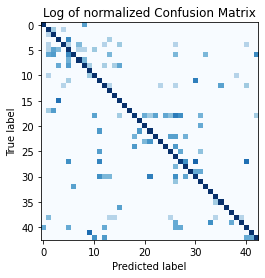

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

We observe some clusters in the confusion matrix above. It turns out that the various speed limits are sometimes misclassified among themselves. Similarly, traffic signs with traingular shape are misclassified among themselves. We can further improve on the model using hierarchical CNNs to first identify broader groups (like speed signs) and then have CNNs to classify finer features (such as the actual speed limit).

---

## Step 7: Testing the Model on New Images

In this step, we will use the model to predict traffic signs type of 5 random images of German traffic signs from the web our model's performance on these images.

In [ ]:
import os
path = "/content/new_test_images"
os.mkdir(path)

In [ ]:
# to remove the folder
!rm -rf new_test_images/

Now, we will take input from the Camera

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
import os
n = 2
try:
  for i in range(n):
    filename = take_photo('/content/new_test_images/photo.jpg')
    print('Saved to {}'.format(filename))
  
    # Show the image which was just taken.
    display(Image(filename))
    # rename the file
    os.rename('/content/new_test_images/photo.jpg', '/content/new_test_images/photo' + str(i+1) + '.jpg')
    
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

End of taking input from Camera

In [ ]:
# Loading and resizing new test images
new_test_images = []
path = 'new_test_images/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)


# new_IDs = []
# numberOfTestImages = len(new_test_images)
# for i in range(numberOfTestImages):
#     n = random.randint(0,42)
#     new_IDs.append(n)


new_IDs = [13, 3, 14, 27, 17]
print("Number of new testing examples: ", len(new_test_images))
print(new_IDs)

Number of new testing examples:  4
[13, 3, 14, 27, 17]


Displaying the new testing examples, with their respective ground-truth labels:

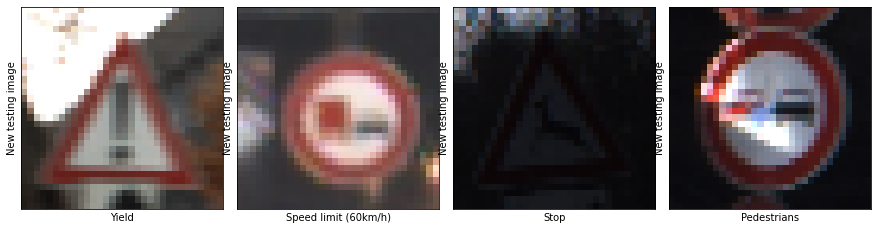

In [ ]:
 plt.figure(figsize=(15, 16))
for i in range(len(new_test_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(signs[new_IDs[i]])
    plt.ylabel("New testing image")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

These test images include some easy to predict signs, and other signs are considered hard for the model to predict.

For instance, we have easy to predict signs like the "Stop" and the "No entry". The two signs are clear and belong to classes where the model can predict with  high accuracy.

On the other hand, we have signs belong to classes where has poor accuracy, like the "Speed limit" sign, because as stated above it turns out that the various speed limits are sometimes misclassified among themselves, and the "Pedestrians" sign, because traffic signs with traingular shape are misclassified among themselves.

In [ ]:
# New test data preprocessing
new_test_images_preprocessed = preprocess(np.asarray(new_test_images))

INFO:tensorflow:Restoring parameters from Saved_Models/VGGNet
New Images Test Accuracy = 0.0%


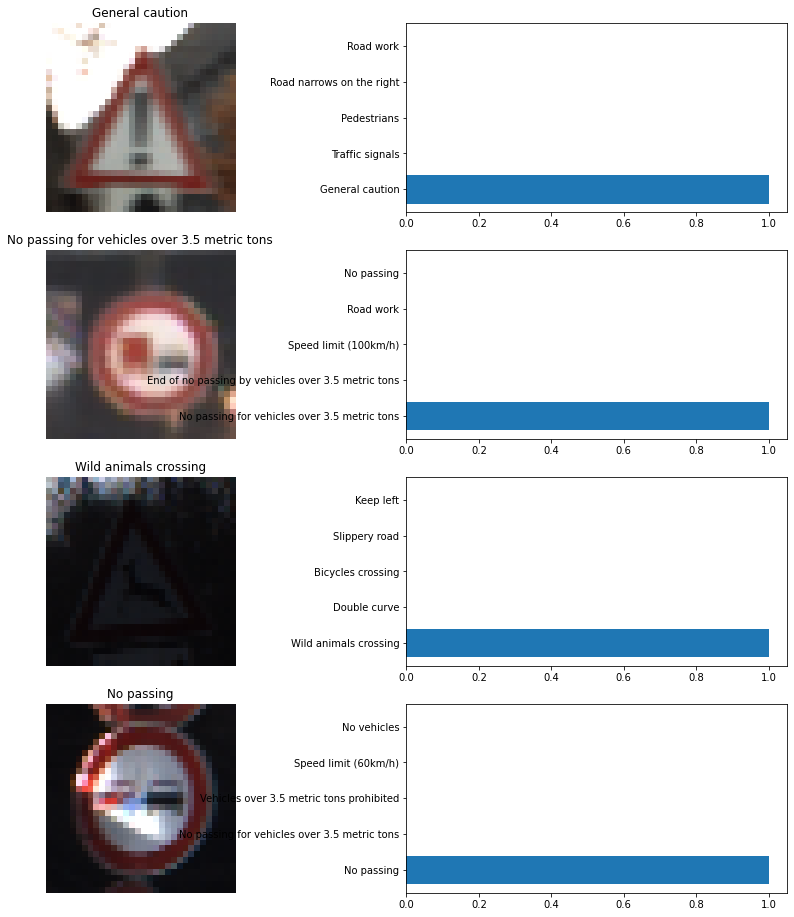

In [ ]:
def y_predict_model(Input_data, top_k=5):
    """
    Generates the predictions of the model over the input data, and outputs the top softmax probabilities.
        Parameters:
            X_data: Input data.
            top_k (Default = 5): The number of top softmax probabilities to be generated.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(VGGNet_Model.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

y_prob, y_pred = y_predict_model(new_test_images_preprocessed)

test_accuracy = 0
for i in enumerate(new_test_images_preprocessed):
    accu = new_IDs[i[0]] == np.asarray(y_pred[i[0]])[0]
    if accu == True:
        test_accuracy += 0.2
print("New Images Test Accuracy = {:.1f}%".format(test_accuracy*100))

results = [] # to store results

plt.figure(figsize=(15, 16))
new_test_images_len=len(new_test_images_preprocessed)
for i in range(new_test_images_len):
    plt.subplot(new_test_images_len, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    plt.title(signs[y_pred[i][0]])
    results.append(signs[y_pred[i][0]]) # storing output in results
    plt.axis('off')
    plt.subplot(new_test_images_len, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :])
    labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()

As we can notice from the top 5 softmax probabilities, the model has very high confidence (100%) when it comes to predict simple signs, like the "Stop" and the "No entry" sign, and even high confidence when predicting simple triangular signs in a very clear image, like the "Yield" sign.

On the other hand, the model's confidence slightly reduces with more complex triangular sign in a "pretty noisy" image, in the "Pedestrian" sign image, we have a triangular sign with a shape inside it, and the images copyrights adds some noise to the image, the model was able to predict the true class, but with 80% confidence.

And in the "Speed limit" sign, we can observe that the model accurately predicted that it's a "Speed limit" sign, but was somehow confused between the different speed limits. However, it predicted the true class at the end.

The VGGNet model was able to predict the right class for each of the 5 new test images. Test Accuracy = 100.0%.
In all cases, the model was very certain (80% - 100%).

In [ ]:
# print(results)
count = 1
for i in results:
    print("The image ", count, " is :", i)
    count = count+1

The image  1  is : General caution
The image  2  is : No passing for vehicles over 3.5 metric tons
The image  3  is : Wild animals crossing
The image  4  is : No passing


In [ ]:
# convert to speech
from gtts import gTTS
from IPython.display import Audio

myString = ""
count = 1
for ele in results:
    myString += "The image " + str(count) + " indicates " + ele + "."
    count += 1
# print(myString)
tts = gTTS(myString)
tts.save('1.wav')
sound_file = '1.wav'
Audio(sound_file, autoplay=False)

---

## Conclusion

Using VGGNet, we've been able to reach a very high accuracy rate. We can observe that the models saturate after nearly 10 epochs, so we can save some computational resources and reduce the number of epochs to 10.
We can also try other preprocessing techniques to further improve the model's accuracy..
We can further improve on the model using hierarchical CNNs to first identify broader groups (like speed signs) and then have CNNs to classify finer features (such as the actual speed limit)
This model will only work on input examples where the traffic signs are centered in the middle of the image. It doesn't have the capability to detect signs in the image corners.